In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import sklearn
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split

import os
os.makedirs('/content/checkpoint', exist_ok=True)
os.makedirs('/content/saved_model', exist_ok=True)


In [ ]:
%matplotlib inline

sns.set(style='whitegrid', palette= 'muted', font_scale=1.5)

RANDOM_SEED = 42

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
columns = ['user','activity','timestamps','x-axis','y-axis','z-axis']
df = pd.read_csv('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header= None, names = columns,on_bad_lines='skip')
df = df.dropna()
df.head()

,user,activity,timestamps,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;


In [ ]:
# Convert columns to strings, remove non-numeric characters, and convert to numeric
df['x-axis'] = pd.to_numeric(df['x-axis'].astype(str).str.replace('[^0-9.-]', '', regex=True), errors='coerce')
df['y-axis'] = pd.to_numeric(df['y-axis'].astype(str).str.replace('[^0-9.-]', '', regex=True), errors='coerce')
df['z-axis'] = pd.to_numeric(df['z-axis'].astype(str).str.replace('[^0-9.-]', '', regex=True), errors='coerce')

In [ ]:
countOfActivities = df['activity'].value_counts()
print(countOfActivities)

activity
Walking       418393
Jogging       336445
Upstairs      122869
Downstairs    100425
Sitting        59939
Standing       48394
Name: count, dtype: int64


In [ ]:
N_TIME_STEPS =200
N_FEATURES = 3
step = 20
segments = []
labels = []

for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].iloc[i:i + N_TIME_STEPS].values
    ys = df['y-axis'].iloc[i:i + N_TIME_STEPS].values
    zs = df['z-axis'].iloc[i:i + N_TIME_STEPS].values
    label = df['activity'].iloc[i:i + N_TIME_STEPS].mode()[0]
    segments.append([xs, ys, zs])
    labels.append(label)


In [ ]:
np.array(segments).shape

(54314, 3, 200)

In [ ]:
segments = np.asarray(segments, dtype=np.float32)
labels = np.asarray(labels)

In [ ]:
reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1,N_TIME_STEPS,N_FEATURES)
reshaped_segments.shape

(54314, 200, 3)

In [ ]:
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [ ]:
print(labels)
print(labels.shape)

[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
(54314, 6)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED
)

In [ ]:
len(X_train)

43451

In [ ]:
len(X_test)

10863

BUILDING MODEL

In [ ]:
N_CLASSES = 6
N_HIDDEN_UNITS = 64

In [ ]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.compat.v1.Variable(tf.random.normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.compat.v1.Variable(tf.random.normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.compat.v1.Variable(tf.random.normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.compat.v1.Variable(tf.random.normal([N_CLASSES]))
    }

    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    lstm_layers = [tf.compat.v1.nn.rnn_cell.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.compat.v1.nn.rnn_cell.MultiRNNCell(lstm_layers)

    outputs, _ = tf.compat.v1.nn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [ ]:
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

X = tf.compat.v1.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name = 'input')
Y = tf.compat.v1.placeholder(tf.float32, [None, N_CLASSES])

In [ ]:
pred_Y = create_LSTM_model(X)
pred_softmax = tf.nn.softmax(pred_Y, name = 'Y_')

In [ ]:
l2_loss = 0.0015
l2 = l2_loss * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.compat.v1.trainable_variables())
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred_Y, labels=Y)) + l2

In [ ]:
LEARNING_RATE = 0.0025
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

# Define accuracy metric
correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [ ]:
N_EPOCHS = 50
BATCH_SIZE = 1024

In [ ]:
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())
saver = tf.compat.v1.train.Saver()


history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

for epoch in range(1, N_EPOCHS + 1):
    # Training loop
    for start, end in zip(range(0, len(X_train), BATCH_SIZE), range(BATCH_SIZE, len(X_train) + 1, BATCH_SIZE)):
        _, acc_train, loss_train = sess.run([optimizer, accuracy, loss], feed_dict={
            X: X_train[start:end],
            Y: y_train[start:end]
        })
        history['train_loss'].append(loss_train)
        history['train_acc'].append(acc_train)

    # Testing loop
    acc_test_list = []
    loss_test_list = []
    for start, end in zip(range(0, len(X_test), BATCH_SIZE), range(BATCH_SIZE, len(X_test) + 1, BATCH_SIZE)):
        acc_test, loss_test = sess.run([accuracy, loss], feed_dict={
            X: X_test[start:end],
            Y: y_test[start:end]
        })
        acc_test_list.append(acc_test)
        loss_test_list.append(loss_test)
    acc_test = sum(acc_test_list) / len(acc_test_list)
    loss_test = sum(loss_test_list) / len(loss_test_list)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    # Print epoch results
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Test Accuracy: {acc_test}, Test Loss: {loss_test}')

# Final evaluation on test set
prediction, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={
    X: X_test,
    Y: y_test
})
print(f'Final Test Accuracy: {acc_final}, Final Test Loss: {loss_final}')

Epoch: 10, Test Accuracy: 0.90986328125, Test Loss: 0.7120626151561738
Epoch: 20, Test Accuracy: 0.96328125, Test Loss: 0.4395726829767227
Epoch: 30, Test Accuracy: 0.959375, Test Loss: 0.3684931695461273
Epoch: 40, Test Accuracy: 0.96279296875, Test Loss: 0.31178302466869356
Epoch: 50, Test Accuracy: 0.973046875, Test Loss: 0.24588191956281663
Final Test Accuracy: 0.972935676574707, Final Test Loss: 0.24584107100963593


In [ ]:
pickle.dump(prediction, open("prediction.p", "wb"))
pickle.dump(history, open("history.p","wb"))

In [ ]:
tf.io.write_graph(sess.graph_def, '/content/checkpoint', 'HAR.pbtxt')
saver.save(sess, save_path="/content/checkpoint/HAR.ckpt")

'/content/checkpoint/HAR.ckpt'

In [ ]:
history = pickle.load(open("history.p", "rb"))
prediction = pickle.load(open("prediction.p", "rb"))

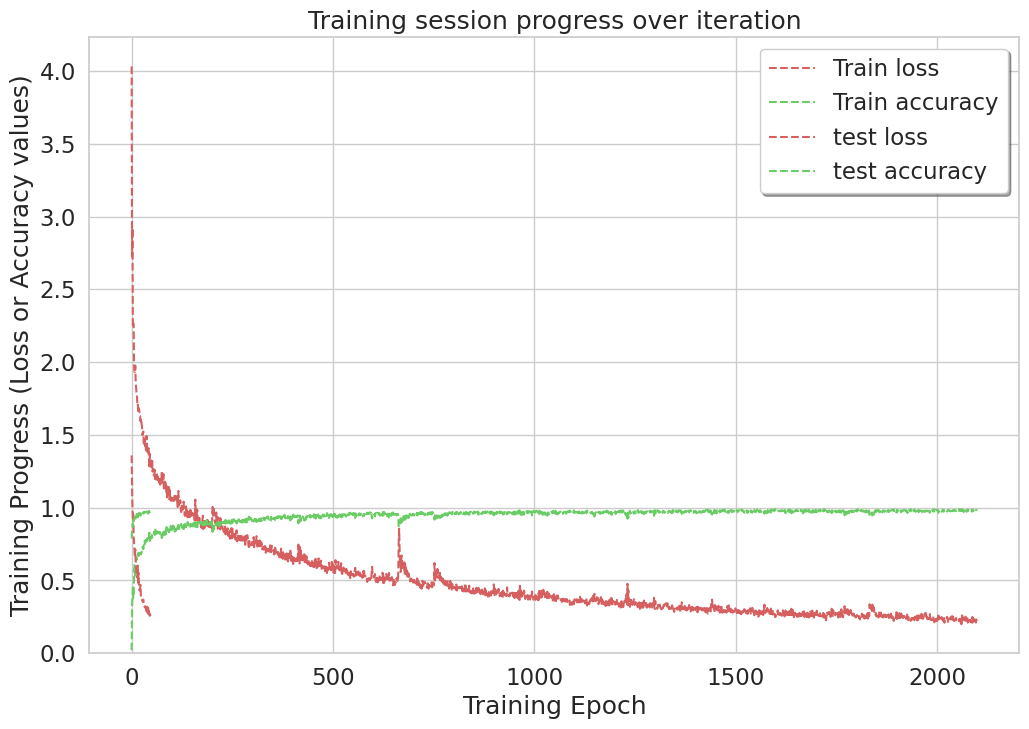

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(np.array(history['train_loss']), "r--", label = "Train loss")
plt.plot(np.array(history['train_acc']), "g--", label = "Train accuracy")

plt.plot(np.array(history['test_loss']), "r--", label = "test loss")
plt.plot(np.array(history['test_acc']), "g--", label = "test accuracy")

plt.title("Training session progress over iteration")
plt.legend(loc = 'upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [ ]:
tf.compat.v1.saved_model.simple_save(
    sess,
    "./saved_model/",
    inputs={"X": X},
    outputs={"Y_": pred_softmax}
)

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


In [ ]:
# Convert the model
converter = tf.compat.v1.lite.TFLiteConverter.from_saved_model("./saved_model/")
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('./saved_model/HAR.tflite', 'wb') as f:
    f.write(tflite_model)

Instructions for updating:
Use `tf.saved_model.load` instead.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


In [ ]:
!pip install tflite_support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.8/238.8 kB 27.0 MB/s eta 0:00:00


In [ ]:
import json

metadata = {
    "name": "Human Activity Recognition Model",
    "description": "Detects human activities based on accelerometer data",
    "version": "v1",
    "author": "Your Name",
    "license": "Apache License. Version 2.0",
    "input": {
        "name": "input",
        "description": "Accelerometer data",
        "shape": [1, 200, 3],
        "dtype": "float32"
    },
    "output": {
        "name": "output",
        "description": "Activity probabilities",
        "shape": [1, 6],
        "dtype": "float32"
    }
}

with open('./saved_model/HAR_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

In [ ]:
sess.close()